# Create Detrended Load Data

- Take the load data files and fit got linear and exponential growth to them
- Normalize them full data set mean value = 1 (not annually as done in the main analysis)
- Create detrended load files for sensitivity analysis

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append("/home/truggles/Inter-annual_Variability_Residual_Load")
from helpers import return_file_info_map

   index  year  month  day  hour   demand (MW)
0  35058  2003      1    1     1  29972.838668
1  35059  2003      1    1     2  29506.685679
2  35060  2003      1    1     3  28652.014481
3  35061  2003      1    1     4  27832.198579
4  35062  2003      1    1     5  27068.465106
[7.46726800e-02 3.17905787e+04]
Linear: 1 year growth: 654 MW
Linear: 1 year growth % yr 1: 2.058%
Y = 32022.06128135009 * e^(-2.016382912456716e-06 * x)
Exp: 1 year growth 1.751%
    index  year  month  day  hour  demand (MW)
0  113922  2006      1    1     1    84246.107
1  113923  2006      1    1     2    81797.543
2  113924  2006      1    1     3    79163.538
3  113925  2006      1    1     4    76298.311
4  113926  2006      1    1     5    73494.207
[1.12188321e-01 7.94092321e+04]
Linear: 1 year growth: 982 MW
Linear: 1 year growth % yr 1: 1.238%
Y = 79663.38634698896 * e^(-1.286079570575627e-06 * x)
Exp: 1 year growth 1.12%
   index  year  month  day  hour  demand (MW)
0      0  2004      1    1     

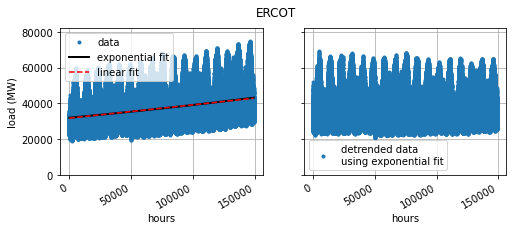

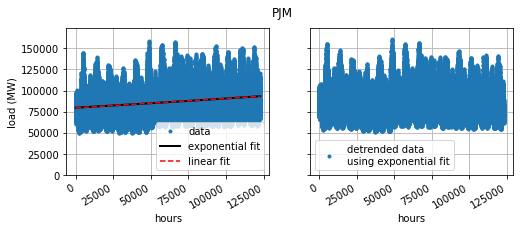

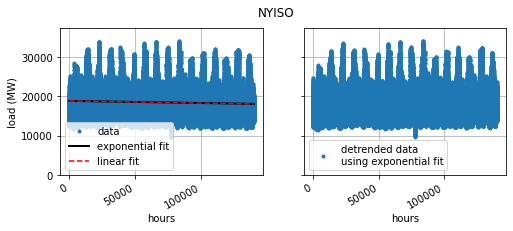

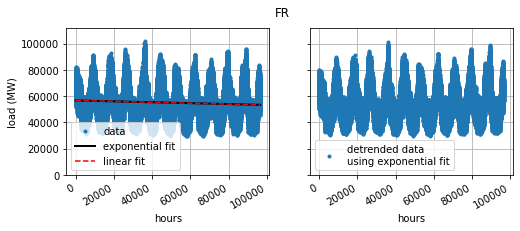

In [2]:
def get_resource_file(ba, resource='demand'):
    ba_info = return_file_info_map( ba )
    #print(ba_info)
    df = pd.read_csv(f"../{ba_info[resource][0]}")
    df = df[ (df['year'] >= ba_info['years'][0]) & (df['year'] <= 2019) ]
    df = df.reset_index()
    print(df.head())
    return df

def linear_fit(df):
    xs = df.index
    ys = df['demand (MW)']
    coef = np.polyfit(xs, ys, 1)
    poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y
    print(coef)
    print(f"Linear: 1 year growth: {int(coef[0]*8760)} MW")
    print(f"Linear: 1 year growth % yr 1: {round(coef[0]*8760/coef[1]*100.,3)}%")
    return coef
    
def monoExp(x, m, t):
    return m * np.exp(t * x)
    
def exp_growth(df):
    xs = df.index
    ys = df['demand (MW)']
    # perform the fit
    p0 = np.array([np.mean(ys), 0.000001]) # start with values near those we expect
    params, cv = curve_fit(monoExp, xs, ys, p0)
    m, t = params
    
    # inspect the parameters
    print(f"Y = {m} * e^(-{t} * x)")
    print(f"Exp: 1 year growth {round((1. - monoExp(0, m, t)/monoExp(8760, m, t))*100.,3)}%")
    
    return m, t

def plot_results(region, df, lin_coef, exp_m, exp_t, save=False):
    # plot the results
    fig, axs = plt.subplots(figsize=(8,3), ncols=2, nrows=1, sharey=True)
    xs = df.index
    ys = df['demand (MW)']
    axs[0].plot(xs, ys, '.', label="data")
    axs[0].plot(xs, monoExp(xs, exp_m, exp_t), '-k', linewidth=2, label="exponential fit")
    poly1d_fn = np.poly1d(lin_coef)
    axs[0].plot(xs, poly1d_fn(xs), '--r', label="linear fit" )
    axs[0].set_ylim(0, np.max(ys)*1.1)
    axs[0].set_xlabel('hours')
    axs[0].set_ylabel('load (MW)')
    axs[0].legend()
    axs[0].grid()
     
    axs[1].plot(xs, ys/monoExp(xs, exp_m, exp_t) * np.mean(ys), '.', label="detrended data\nusing exponential fit")
    axs[1].legend(ncol=2)
    axs[1].set_xlabel('hours')
    axs[1].grid()
    fig.autofmt_xdate(rotation=30)

    plt.suptitle(f"{region}")
    plt.savefig(f"{region}.png")
    
    if save:
        df['demand (MW)'] = ys/monoExp(xs, exp_m, exp_t)
        ba_info = return_file_info_map( region )
        df.to_csv(f"../{ba_info['demand'][0].replace('.csv', '_expDT.csv')}")
        #fig, ax = plt.subplots()
        #ax.plot(df.index, df['demand (MW)'])
        #fig.savefig(f"{region}_for_use.png")


    

save = True
#save = False

for region in ['ERCOT', 'PJM', 'NYISO', 'FR']:
    df = get_resource_file(region)
    lin_coef = linear_fit(df)
    exp_m, exp_t = exp_growth(df)
    plot_results(region, df, lin_coef, exp_m, exp_t, save)